完成したはず

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pickle5
import pickle5 as pickle
import gc
import os
import glob
import tqdm
import numpy as np
import pandas as pd
import zipfile
from pathlib import Path
from sklearn.decomposition import IncrementalPCA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 3.9 MB/s 


In [ ]:
train_folder = "/content/drive/MyDrive/competition/Amex0824/data/train"
test_folder = "/content/drive/MyDrive/competition/Amex0824/data/test"
extension = ".pkl"

In [ ]:
pkl_files_list = ['after_pay.pkl','count.pkl','date.pkl','frequency.pkl','nunique.pkl']

In [ ]:
#carry out Incremetal PCA
def IPCA(df_train, df_test, features_name_train, features_name_test, name):
    """  受け取ったデータを主成分分析し、「主成分得点に変換された値」のデータを生成する関数
    
    Args:
    df_train(DataFrame)       : 学習用データ
    df_test(DataFrame)        : テストデータ
    features_name_train(list) : 学習用データのindex
    features_name_test(list)  : テストデータのindex
    name(list)                : 分析したfileの名前

    return :
    features_train(DataFrame) : 主成分得点に変換した学習用データ
    features_test(DataFrame)  : 主成分得点に変換したテストデータ
    
    """
    #分割回数
    n_batches = 100
    
    #第何主成分まで抽出するか決める(10次元)
    inc_pca = IncrementalPCA(n_components=10)

    #データをn_batchで分割して逐次的に計算
    for X_batch in np.array_split(df_train,n_batches):
        print(".",end="")
        inc_pca = inc_pca.partial_fit(X_batch)

    #num_featuresをPCAで変換された値に変形する(trainとtest両方変換する)
    features_train = inc_pca.transform(df_train)
    features_test = inc_pca.transform(df_test)
    del df_train,df_test
    
    #主成分で得たデータをデータフレーム型に変換
    features_train = pd.DataFrame(features_train,index = features_name_train,columns =[f"{name}_" + "PC{}".format(x+1) for x in range(len(inc_pca.explained_variance_ratio_))]) 
    features_test = pd.DataFrame(features_test,index = features_name_test,columns =[f"{name}_" + "PC{}".format(x+1) for x in range(len(inc_pca.explained_variance_ratio_))])  

    #寄与率を表示
    explained_variance_ratio_ = pd.DataFrame(inc_pca.explained_variance_ratio_,index=[f"{name}_" + "PC{}".format(x+1) for x in range(len(inc_pca.explained_variance_ratio_))])
    print(explained_variance_ratio_)

    #寄与率をリスト型に渡し、、for文で取り出し可能にする
    explained_variance_ratio_ = list(inc_pca.explained_variance_ratio_)
    
    #初期化
    cumulative_contribution_ratios = 0
    count_features = 0
    
    #累積寄与率を計算
    for i in explained_variance_ratio_:
        cumulative_contribution_ratios += i
        count_features = count_features + 1
        if cumulative_contribution_ratios >= 0.99:
            break
    print("累積寄与率")
    print(cumulative_contribution_ratios)
    print("\n")
    print("第何主成分までを利用するか")
    print(count_features)

    #trainを抽出
    features_train = features_train.iloc[:,:int(count_features)]
    features_train = pd.DataFrame(features_train)
    
    #testを抽出
    features_test = features_test.iloc[:,:int(count_features)]
    features_test = pd.DataFrame(features_test)

    #抽出したデータを返す
    return features_train, features_test

In [ ]:
train_folder = "/content/drive/MyDrive/competition/Amex0824/data/train"
test_folder = "/content/drive/MyDrive/competition/Amex0824/data/test"
extension = ".pkl"

In [ ]:
pkl_files_list = ['after_pay.pkl','count.pkl','date.pkl','frequency.pkl','nunique.pkl']

In [ ]:
!pip3 install pickle5
import pickle5 as pickle

def make_pc(train_folder = train_folder, test_folder = test_folder, extension = extension):
    #splitしてしてファイル名の「train_」を消す
    #files_list = get_file_list()
    #files_list = list(['after_pay','count','date','frequency','nunique'])
    #split_files_list = []
    #for file in files_list:
        #split = list(file.split('train_'))
        #split = list(filter(lambda x: not len(x)==0,split))
        #split_files_list += split

    for file in pkl_files_list:
        with zipfile.ZipFile(train_folder + f".zip") as zip_train_file:
            zip_train_file.extract(file)
        with open('/content/' + f'{file}' , "rb") as fh:
            train = pickle.load(fh)
            print(file)
        #train_file_name = train_folder + f"/{file}" + extension
        #train = pd.read_pickle(train_file_name)

        features_name_train = train.index
        train_list = train.columns.tolist()

        with zipfile.ZipFile(test_folder + f".zip") as zip_test_file:
            zip_test_file.extract(file)
        with open('/content/' + f'{file}' , "rb") as fh:
            test = pickle.load(fh)
            print(file)
        #test_file_name = test_folder + f"/{file}" + extension
        #test = pd.read_pickle(test_file_name)

        #変数番号を取っておく
        #features_name_train = train.index
        features_name_test = test.index

        #train_list = train.columns.tolist()
        test_list = test.columns.tolist()

        # 欠損値を -1 に補完
        train = train.fillna(-1)
        test = test.fillna(-1)

        train, test = IPCA(train, test, features_name_train, features_name_test, file)

        #make a csv-file 
        save_train = '/content/drive/MyDrive/competition/Amex0824/data/ipca_train/' + f"{file}"
        save_test = '/content/drive/MyDrive/competition/Amex0824/data/ipca_test/' + f"{file}" 
        train.to_pickle(save_train)
        test.to_pickle(save_test)

        del train,test

make_pc()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
after_pay.pkl
after_pay.pkl
....................................................................................................                               0
after_pay.pkl_PC1   9.898863e-01
after_pay.pkl_PC2   1.011370e-02
after_pay.pkl_PC3   3.029131e-16
after_pay.pkl_PC4   3.482402e-19
after_pay.pkl_PC5   9.573872e-36
after_pay.pkl_PC6   1.658859e-36
after_pay.pkl_PC7   2.145881e-51
after_pay.pkl_PC8   0.000000e+00
after_pay.pkl_PC9   0.000000e+00
after_pay.pkl_PC10  0.000000e+00
累積寄与率
0.9999999923004154


第何主成分までを利用するか
2
count.pkl
count.pkl
....................................................................................................                           0
count.pkl_PC1   1.000000e+00
count.pkl_PC2   4.471963e-27
count.pkl_PC3   1.134469e-30
count.pkl_PC4   6.276944e-32
count.pkl_PC5   1.043351e-56
count.pkl_PC6   1.014150e-57
count.pkl_PC7   1.612497e-61
count.pkl_PC8  

以下はデータを結合するコード

In [5]:
train_pickle_folder = "/content/drive/MyDrive/competition/Amex0824/data/"
test_pickle_folder = "/content/drive/MyDrive/competition/Amex0824/data/"
extension = ".pkl"

In [ ]:
def get_file_list(folder = train_pickle_folder):
    train_files = sorted(glob.glob(os.path.join(folder, "*.pkl")))
    file_list = []
    for file in train_files:
        file_list.append(Path(file).stem)
    return file_list

In [ ]:
def merge_pca(train_pidkle_folder = train_pickle_folder, test_pickle_folder = test_pickle_folder, extension = extension):
    """pcaで得られたデータを結合して一つにまとめる関数

    return :
    df_train_all(DataFrame) : PCA通した学習用データを全結合したもの
    df_test_all(DataFrame)  : PCA通したテストデータを全結合したもの
    
    """

    df_pca_train = pd.DataFrame() 
    df_pca_test = pd.DataFrame()
    for file in pkl_files_list:
        train_file_name = train_pickle_folder + f"{file}" 
        test_file_name = test_pickle_folder + f"/{file}" 
        train = pd.read_pickle(train_file_name)
        test = pd.read_pickle(test_file_name)
    
        #for文でデータフレームを結合するコードを作る
        df_pca_train = pd.concat([df_pca_train,train], axis = 1)
        df_pca_test = pd.concat([df_pca_test,test], axis = 1)
        del train,test

    ipca_train = pd.read_csv('/content/drive/MyDrive/competition/Amex0824/data/ipca_features_train.csv')
    ipca_test = pd.read_csv('/content/drive/MyDrive/competition/Amex0824/data/ipca_features_test.csv')

    ipca_train = ipca_train.drop(columns = ipca_train.columns[0])
    ipca_test = ipca_test.drop(columns = ipca_test.columns[0])
    pca_name_train = df_pca_train.index
    pca_name_test = df_pca_test.index
    ipca_train.index = pca_name_train
    ipca_test.index  = pca_name_test

    df_pca_train = pd.concat([df_pca_train,ipca_train], axis = 1)
    df_pca_test = pd.concat([df_pca_test,ipca_test], axis = 1)

    del ipca_train,ipca_test

    df_train_all = pd.DataFrame(df_pca_train)
    df_test_all = pd.DataFrame(df_pca_test)
    #make a pickle_file 
    save_train = '/content/drive/MyDrive/competition/Amex0824/data/ipca_train/df_train_all' +extension
    save_test = '/content/drive/MyDrive/competition/Amex0824/data/ipca_test/df_test_all' +extension
    df_train_all.to_pickle(save_train)
    df_test_all.to_pickle(save_test)

merge_pca()

In [6]:
train_pca_all = pd.read_pickle(train_pickle_folder +f"df_train_all.pkl")
train_pca_all.head(5)

,after_pay.pkl_PC1,after_pay.pkl_PC2,count.pkl_PC1,date.pkl_PC1,date.pkl_PC2,date.pkl_PC3,date.pkl_PC4,date.pkl_PC5,date.pkl_PC6,date.pkl_PC7,...,nunique.pkl_PC3,nunique.pkl_PC4,nunique.pkl_PC5,nunique.pkl_PC6,nunique.pkl_PC7,nunique.pkl_PC8,nunique.pkl_PC9,nunique.pkl_PC10,PC1,PC2
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.792036,-0.021208,0.850869,-1.406126,-0.049793,-0.380938,-0.765362,-0.422201,0.246151,-0.446322,...,-0.649401,-0.12776,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1885.969081,-168.313406
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.790675,-0.022269,0.850869,-1.037694,0.090119,-0.029977,-1.335747,-0.359705,0.294483,-0.623735,...,-0.649401,-0.12776,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1885.970086,-168.314749
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.330825,-0.024651,0.850869,-0.293457,-0.280492,2.307900,-1.119098,1.139195,-0.882136,0.740000,...,-0.649401,-0.12776,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,2189.431372,-56.574431
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.794137,-0.022477,0.850869,0.175731,-0.232409,-1.121780,-1.607717,0.195904,-0.064205,-0.318195,...,-0.649401,-0.12776,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1225.824650,-13.755297
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.789267,-0.025325,0.850869,0.859516,0.277764,2.223003,-1.256485,0.292063,-0.348169,-0.194827,...,-0.649401,-0.12776,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1885.975755,-168.304032


In [7]:
test_pca_all = pd.read_pickle(test_pickle_folder + f"df_test_all.pkl")
test_pca_all.head(5)

,after_pay.pkl_PC1,after_pay.pkl_PC2,count.pkl_PC1,date.pkl_PC1,date.pkl_PC2,date.pkl_PC3,date.pkl_PC4,date.pkl_PC5,date.pkl_PC6,date.pkl_PC7,...,nunique.pkl_PC3,nunique.pkl_PC4,nunique.pkl_PC5,nunique.pkl_PC6,nunique.pkl_PC7,nunique.pkl_PC8,nunique.pkl_PC9,nunique.pkl_PC10,PC1,PC2
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-1.153537,0.260676,29.849474,-859.509631,-54.226585,14.806255,812.848283,-263.420013,48.330594,64.980922,...,0.967062,0.881983,0.395288,0.049912,0.434518,0.429469,-0.046607,-0.033429,11.222297,158.940195
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-1.122117,0.292096,29.849474,-840.615471,-55.701881,14.182065,819.193533,-260.987490,45.722486,69.825381,...,0.967062,0.881983,0.395288,0.049912,0.434518,0.429469,-0.046607,-0.033429,-408.212041,420.447347
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-1.137654,0.276559,29.849474,-823.401304,-54.830278,16.142231,823.803559,-261.826333,45.530588,70.974787,...,0.967062,0.881983,0.395288,0.049912,0.434518,0.429469,-0.046607,-0.033429,-377.040414,553.734867
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-1.141797,0.272416,29.849474,-809.508599,-53.073602,13.776100,826.513076,-265.306973,47.315865,68.878625,...,0.967062,0.881983,0.395288,0.049912,0.434518,0.429469,-0.046607,-0.033429,-377.067907,553.627316
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,10.472638,0.004143,29.849474,-794.963875,-50.288659,17.658792,829.591147,-268.907826,49.090992,66.825861,...,0.967062,0.881983,0.395288,0.049912,0.434518,0.429469,-0.046607,-0.033429,78.626379,446.971514


In [ ]:
len(train_pca_all)

5531451

In [ ]:
len(test_pca_all)

11363762

In [13]:
x = train_pca_all['after_pay.pkl_PC1']
y = train_pca_all['after_pay.pkl_PC2']

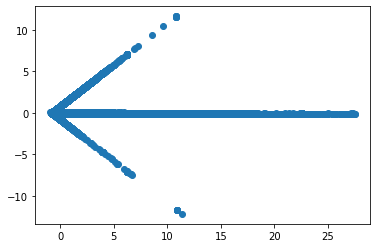

In [14]:
import matplotlib.pyplot as plt
plt.scatter(x,y)
plt.show()